# Titanic Dataset Kaggle

El hundimiento del Titanic es uno de los naufragios más infames de la historia.

El 15 de abril de 1912, durante su viaje inaugural, el RMS Titanic, ampliamente considerado "insumergible", se hundió tras chocar con un iceberg. Desafortunadamente, no había suficientes botes salvavidas para todos a bordo, lo que resultó en la muerte de 1502 de los 2224 pasajeros y la tripulación.

Si bien hubo algún elemento de suerte involucrado en sobrevivir, parece que algunos grupos de personas tenían más probabilidades de sobrevivir que otros.

En este desafío, le pedimos que cree un modelo predictivo que responda a la pregunta: "¿Qué tipo de personas tenían más probabilidades de sobrevivir?" utilizando datos de pasajeros (es decir, nombre, edad, sexo, clase socioeconómica, etc.).

<hr>

## Importación de algunas bibliotecas de Python

In [294]:
# datos
import pandas as pd
import numpy as np

# visualizacion
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
sns.set_palette("deep")


<hr>

## Descargar el conjunto de datos en formato .csv

In [295]:
train_data = pd.read_csv("train.csv")
train_data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [296]:
test_data = pd.read_csv("test.csv")
test_data.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


## En el conjunto de datos proporcionado, tenemos las siguientes columnas:

* PassengerId
* Pclass
* Name
* Sex
* Age
* SibSp
* Parch
* Ticket
* Fare
* Cabin
* Embarked
* **Survived = El valor "target" que se va a predecir**

Podemos verificar fácilmente que faltan valores usando el siguiente código.

Se debe manejar cuidadosamente estos valores faltantes antes de crear un modelo de clasificación.

<hr>

## Manejando los valores Nulos

In [297]:
# Mostrando los datos nulos del dataset antes de la primera transformación
print("Valores nulos del dataset: \n\n{}\n".format(train_data.isnull().sum(axis = 0)))

Valores nulos del dataset: 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64



Como se puede observar, hay 687 datos nulos en la columna cabin.
Teniendo en cuenta que son 890 datos en total, lo mejor sería eliminar esa columna.

In [298]:
df = train_data.drop("Cabin", axis = 1)
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,Q


Para remplazar los demás valores nulos se ultilizará un Iterative Imputer experminetal de la librería *sklearn*.

Pero primero, es necesario transformar los valores de Embarked a tipo númerico.

In [299]:
df.Embarked.unique()

array(['S', 'C', 'Q', nan], dtype=object)

Se hace un mapeo de los valores categoricos a valores enteros:

In [300]:
cleanup_nums = {"Embarked": {"S": 0,
                             "C": 1,
                             "Q": 2}}
df1 = df.replace(cleanup_nums, inplace=False)
df1.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,0.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,0.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,0.0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,1.0
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,2.0


Se realiza el Imputer sobre las columnas que presentan valores nulos.

In [301]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(df1[["Age", "Embarked"]])
IterativeImputer(random_state=0)
df1[["Age", "Embarked"]] = pd.DataFrame(imp_mean.transform(df1[["Age", "Embarked"]]), columns= df1[["Age", "Embarked"]].columns)
df1.Embarked = np.round(df1.Embarked)
df1.Age = np.round(df1.Embarked)
df1.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,0.0,0,0,211536,13.00,0.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,0.0,0,0,112053,30.00,0.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,0.0,1,2,W./C. 6607,23.45,0.0
889,890,1,1,"Behr, Mr. Karl Howell",male,1.0,0,0,111369,30.00,1.0
890,891,0,3,"Dooley, Mr. Patrick",male,2.0,0,0,370376,7.75,2.0


In [302]:
# Mostrando los datos nulos del dataset
print("Valores nulos del dataset: \n\n{}\n".format(df1.isnull().sum(axis = 0)))

Valores nulos del dataset: 

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64



<hr>

## Escogiendo los predictores

Al comparar la proprción de sobrevivientes con respecto al sexo nos damos cuenta de que hay una clara relación.

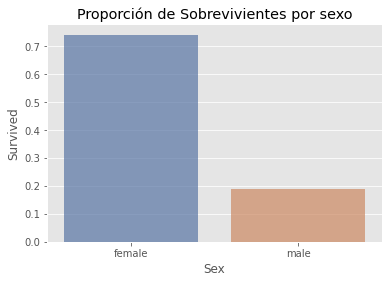

In [303]:
df_ = df1[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
sns.barplot(x = df_.Sex, y = df_.Survived, alpha = 0.7)
plt.title("Proporción de Sobrevivientes por sexo")
plt.show()

Lo mismo ocurre con las clases, estan también presentan una relación.

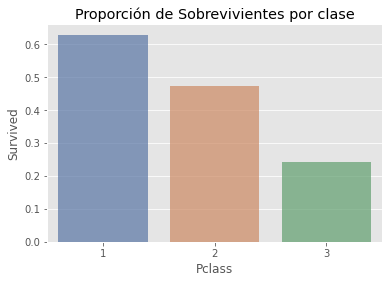

In [304]:
df_ = df1[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)
sns.barplot(x = df_.Pclass, y = df_.Survived, alpha = 0.7)
plt.title("Proporción de Sobrevivientes por clase")
plt.show()

Ahora si nos fijos en la edad, hay ciertos grupos de edad en los que la proporcion de muertes fue muy diferente a la de sobrevivientes, por lo que también podrían ser predictores.

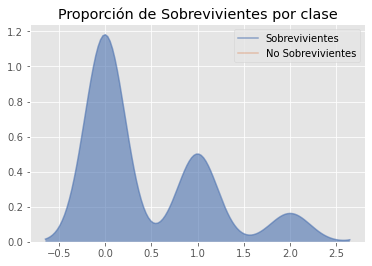

In [305]:
sns.kdeplot(df1[df1.Survived == 1].Age, shade=True, label = "Sobrevivientes", alpha = 0.6)
sns.kdeplot(df1[df1.Survived == 0].Age, shade=True, label = "No Sobrevivientes", alpha = 0.4)
plt.title("Proporción de Sobrevivientes por clase")
plt.show()

También la edad presenta una relación con el sexo de la persona.

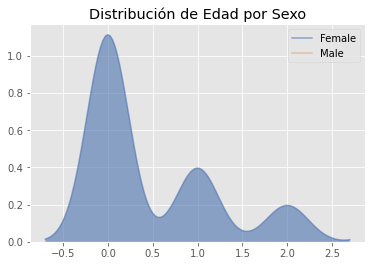

In [306]:
sns.kdeplot(df1[df1.Sex == "female"].Age, shade=True, label = "Female", alpha = 0.6)
sns.kdeplot(df1[df1.Sex == "male"].Age, shade=True, label = "Male", alpha = 0.4)
plt.title("Distribución de Edad por Sexo")
plt.show()

Ahora si nos fijamos en la relación de supervivencia con el número de hermanos o pareja, también existe una relación.

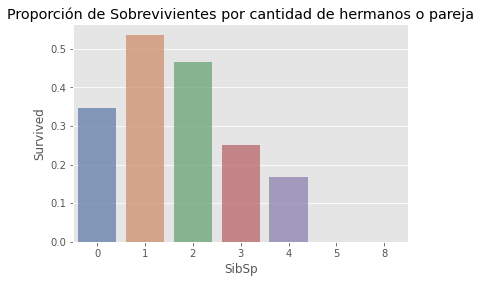

In [307]:
df_ = df1[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='SibSp', ascending=False)
sns.barplot(x = df_.SibSp, y = df_.Survived, alpha = 0.7)
plt.title("Proporción de Sobrevivientes por cantidad de hermanos o pareja")
plt.show()

Lo mismo ocurre con el número de padres e hijos.

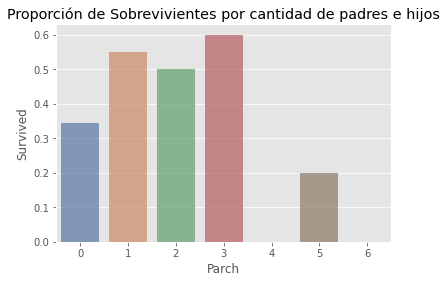

In [308]:
df_ = df1[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)
sns.barplot(x = df_.Parch, y = df_.Survived, alpha = 0.7)
plt.title("Proporción de Sobrevivientes por cantidad de padres e hijos")
plt.show()

Y si comparamos el precio por el que pagaron por el boleto con respecto a la proporción de supervivencia, también encontramos una relación.

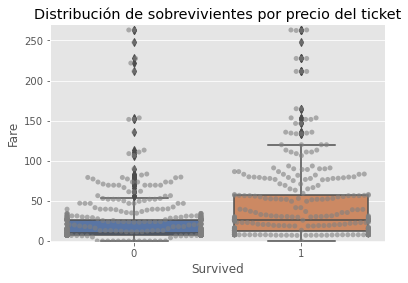

In [309]:
sns.boxplot(x = df1.Survived, y = df1.Fare)
sns.swarmplot(x= df1.Survived, y= df1.Fare, color="grey", alpha = 0.6)
plt.ylim(-1,270)
plt.title("Distribución de sobrevivientes por precio del ticket")
plt.show()

Sin embargo, el número de pasajero no nos otorga nada de información.

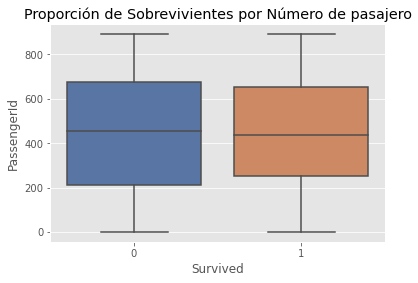

In [310]:
sns.boxplot(x = df1.Survived, y = df1.PassengerId)
plt.title("Proporción de Sobrevivientes por Número de pasajero")
plt.show()

Lo mismo aplca para el ticket, es muy caotico.

In [311]:
df1.Ticket.unique()[:20]

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649'], dtype=object)

Y por ultimo, el puerto de Embarcación también podría ser un buen indicador.

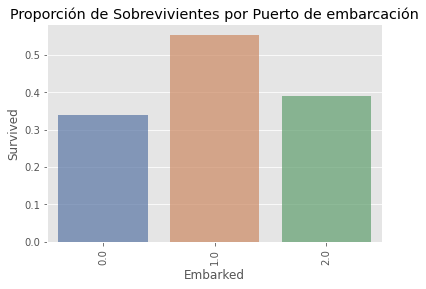

In [312]:
df_ = df1[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().sort_values(by='Embarked', ascending=False)
sns.barplot(x = df_.Embarked, y = df_.Survived, alpha = 0.7)
plt.title("Proporción de Sobrevivientes por Puerto de embarcación")
plt.xticks(rotation = 90)
plt.show()

In [313]:
df2 = df1
df2.Sex = pd.get_dummies(df1['Sex'])
df2.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
886,887,0,2,"Montvila, Rev. Juozas",0,0.0,0,0,211536,13.00,0.0
887,888,1,1,"Graham, Miss. Margaret Edith",1,0.0,0,0,112053,30.00,0.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,0.0,1,2,W./C. 6607,23.45,0.0
889,890,1,1,"Behr, Mr. Karl Howell",0,1.0,0,0,111369,30.00,1.0
890,891,0,3,"Dooley, Mr. Patrick",0,2.0,0,0,370376,7.75,2.0


<hr>

## Features y normalizacion

Seleccionamos los predictores y el target

In [314]:
features = df1.drop(['Survived', 'PassengerId', 'Name', 'Ticket'], axis = 1)
target = df1['Survived']
features.tail()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
886,2,0,0.0,0,0,13.00,0.0
887,1,1,0.0,0,0,30.00,0.0
888,3,1,0.0,1,2,23.45,0.0
889,1,0,1.0,0,0,30.00,1.0
890,3,0,2.0,0,0,7.75,2.0


Normalizamos los predictores

In [315]:
from sklearn.preprocessing import StandardScaler

col_names = features.columns
scaler = StandardScaler()
scaler.fit(features)
features = pd.DataFrame(scaler.transform(features), columns = col_names)
features.tail()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
886,-0.369365,-0.737695,-0.568837,-0.474545,-0.473674,-0.386671,-0.568837
887,-1.566107,1.355574,-0.568837,-0.474545,-0.473674,-0.044381,-0.568837
888,0.827377,1.355574,-0.568837,0.432793,2.008933,-0.176263,-0.568837
889,-1.566107,-0.737695,1.005181,-0.474545,-0.473674,-0.044381,1.005181
890,0.827377,-0.737695,2.579199,-0.474545,-0.473674,-0.492378,2.579199


<hr>

## Modelo

Dividiendo el conjunto de datos en conjuntos de entrenamiento y pruebas

In [316]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=133)

In [317]:
from sklearn import svm

model = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)

y_pred = model.predict(X_test)
print(y_pred)

[1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0
 1 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0
 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 1
 1 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0]


Funcion para imprimir una matriz de confusión

In [318]:
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('BuPu')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Predicción

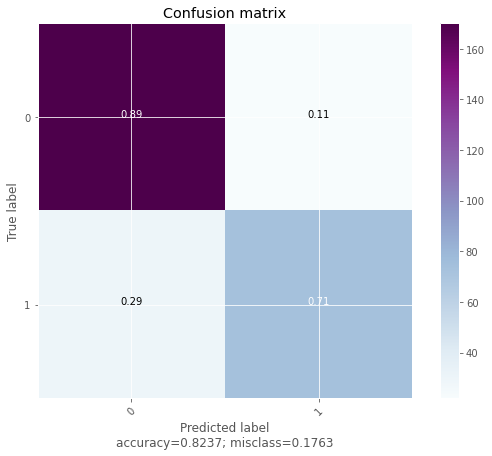

In [319]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(confusion_matrix(y_test, y_pred), [0,1])

Precisión con Cross-Validation

In [320]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(modelo, features, target, cv=5)
print(scores.mean())

0.7867365513778168


<hr>

## Predicción en el test csv

Ahora utilizaremos el modelo para predecir la supervivencia de las personas en el test 2

In [321]:
test_data.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


Borramos las columnas que no son predictores

In [322]:
df_out = test_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
df_out.tail()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
413,3,male,NaN,0,0,8.0500,S
414,1,female,39.0,0,0,108.9000,C
415,3,male,38.5,0,0,7.2500,S
416,3,male,NaN,0,0,8.0500,S
417,3,male,NaN,1,1,22.3583,C


Converitmos los valores no numericos

In [323]:
cleanup_nums = {"Embarked": {"S": 0,
                             "C": 1,
                             "Q": 2}}
df_out1 = df_out.replace(cleanup_nums, inplace=False)
df_out1.Sex = pd.get_dummies(df_out1['Sex'])
df_out1.tail()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
413,3,0,NaN,0,0,8.0500,0
414,1,1,39.0,0,0,108.9000,1
415,3,0,38.5,0,0,7.2500,0
416,3,0,NaN,0,0,8.0500,0
417,3,0,NaN,1,1,22.3583,1


Revisamos valores nulos

In [324]:
# Mostrando los datos nulos del dataset antes de la primera transformación
print("Valores nulos del dataset: \n\n{}\n".format(df_out.isnull().sum(axis = 0)))

Valores nulos del dataset: 

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64



Imputamos esos datos

In [325]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(df_out1[["Age", "Fare"]])
IterativeImputer(random_state=0)
df_out1[["Age", "Fare"]] = pd.DataFrame(imp_mean.transform(df_out1[["Age", "Fare"]]), columns= df_out1[["Age", "Fare"]].columns)
df_out1.Fare = np.round(df1.Fare)
df_out1.Age = np.round(df1.Embarked)
df_out1.tail()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
413,3,0,0.0,0,0,0.0,0
414,1,1,0.0,0,0,8.0,1
415,3,0,0.0,0,0,8.0,0
416,3,0,0.0,0,0,32.0,0
417,3,0,0.0,1,1,13.0,1


Volvemos a revisar los valores nulos

In [326]:
print("Valores nulos del dataset: \n\n{}\n".format(df_out1.isnull().sum(axis = 0)))

Valores nulos del dataset: 

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64



Hacemos la prediccion y guardamos como pdf

In [327]:
predictions = model.predict(df_out1)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.tail()

# output.to_csv('my_submission.csv', index=False)
# print("Your submission was successfully saved!")

,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0
